<a href="https://colab.research.google.com/github/amitkumar981/Learn_RAG/blob/master/CorrectiveRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# load env variables
from dotenv import load_dotenv
import os

load_dotenv(override=True)

os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')



In [ ]:
# create vectorestore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]

docs_list = [item for sublist in docs for item in sublist]

docs_list



e:\desktop backup\RAG\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
docs = text_splitter.split_documents(docs_list)
vectorstore = FAISS.from_documents(docs,OpenAIEmbeddings())
retriever = vectorstore.as_retriever()
retriever.invoke("what is prompt engineering?")

[Document(id='a035b571-3a25-4c28-b3bc-d229663d613c', metadata={'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log", 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'language': 'en'}, page_content='Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for

In [ ]:
# confure llm
from langchain.chat_models import init_chat_model
llm = init_chat_model(model ='openai:gpt-4o-mini',temperature=0.2)

llm.invoke('hi')

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_29330a9688', 'id': 'chatcmpl-CsHp5086qncDnhMOEkrmNlf5st6ds', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b6ca4-3131-7443-b350-cb72c6d6fcff-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [ ]:
#configure state
from typing import List
from langchain_core.documents import Document
from typing_extensions import TypedDict

class RAGState(TypedDict):
    question:str
    #rewritten_question:str
    answer:str
    documents:List[Document]
    grade: str


In [ ]:
# create retrieve node
from langchain_core.prompts import PromptTemplate
def retrieve_from_documents(state):
    "retrieve documents from vectorstore based on the question"
    print("RETRIEVE FROM DOCUMENTS...")
    question = state['question']
    docs=retriever.invoke(question)
    return {'documents':docs}


In [ ]:
state = RAGState(question='what is prompt engineering?',answer='',retrieved_docs=[])
retrieve_from_documents(state)

RETRIEVE FROM DOCUMENTS...


{'documents': [Document(id='a035b571-3a25-4c28-b3bc-d229663d613c', metadata={'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log", 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'language': 'en'}, page_content='Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer it

In [ ]:
from typing import Literal
from pydantic import BaseModel, Field
from langchain_core.prompts import PromptTemplate

def grade_documents(state):
    """Grade retrieved documents for relevance to the question"""

    print("CHECKING DOCUMENT RELEVANCE...")

    question = state["question"]
    docs = state["documents"]

    # Convert docs to plain text
    docs_text = "\n\n".join([doc.page_content for doc in docs])

    prompt = PromptTemplate(
        template="""
You are a relevance grader.

Given the question and the retrieved documents, determine whether the documents
contain information that helps answer the question.

Question:
{question}

Documents:
{documents}

Respond with ONLY one word: yes or no.
""",
        input_variables=["question", "documents"]
    )

    class GradeDocuments(BaseModel):
        """Binary relevance score."""
        binary_score: Literal["yes", "no"] = Field(
            description="Whether documents are relevant to the question"
        )

    grader = llm.with_structured_output(GradeDocuments)

    response = grader.invoke(
        prompt.format(question=question, documents=docs_text)
    )

    grade = 'approve' if response.binary_score == 'yes' else 'web_search'

    return {
        "grade": grade,
    }


In [ ]:
from langchain_core.prompts import PromptTemplate

def transform_query(state):
    """Rewrite the question using context from retrieved documents"""

    print("TRANSFORMING QUERY...")

    question = state["question"]
    docs = state["documents"]

    # Extract document text only
    docs_text = "\n\n".join([doc.page_content for doc in docs])

    prompt = PromptTemplate(
        template="""
You are a query rewriter for a Retrieval-Augmented Generation system.

Given the original question and retrieved documents:
- Rewrite the question to improve retrieval quality
- Preserve the original intent and meaning
- Do NOT answer the question
- Return ONLY the rewritten question

Original Question:
{question}

Retrieved Documents:
{documents}
""",
        input_variables=["question", "documents"]
    )

    response = llm.invoke(
        prompt.format(question=question, documents=docs_text)
    )

    rewritten_question = response.content.strip()

    return {
        "question": rewritten_question,
    }


In [ ]:
#define web search node
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.documents import Document

def web_search(state):
    """Perform web search using the rewritten question"""

    print("WEB SEARCH...")

    question = state["question"]
    existing_docs = state.get("documents", [])

    search_tool = TavilySearchResults(
        k=5,
        include_raw_content=True
    )

    web_results = search_tool.invoke(question)

    # Convert web results to Documents
    web_docs = [
        Document(page_content=result["content"])
        for result in web_results
        if result.get("content")
    ]

    # Return a NEW list (do not mutate state)
    return {
        "documents":web_docs
    }



In [ ]:
from langchain_core.output_parsers import StrOutputParser
def generate(state):
    "generate response based on the retrieved documents"
    print("GENERATING ANSWER...")
    question = state['question']
    docs = state['documents']
    context = "\n\n".join([doc.page_content for doc in docs])
    prompt = PromptTemplate(
        template="""You are answering a complex question using retrieved documents.

Question:
{question}

Relevant Information:
{context}

Now synthesize a clear, accurate, and well-reasoned final answer.
""",
    input_variables=["question", "context"]
    )

    parser = StrOutputParser()
    response = parser.parse(
        llm.invoke(prompt.format(question=question, context=context))
    )
    return {'answer':response}



In [ ]:
def route(state):
    "Determine weather to generate answer or re-generate a question"
    print("ROUTING...")
    if state['grade']=='web_search':
        print("DOCUMENTS ARE NOT RELEVANT TO QUESTION, REGENERATE QUESTION")
        return "transform_query"
    else:
        print("DOCUMENTS ARE RELEVANT TO QUESTION, GENERATE ANSWER")
        return "generate"



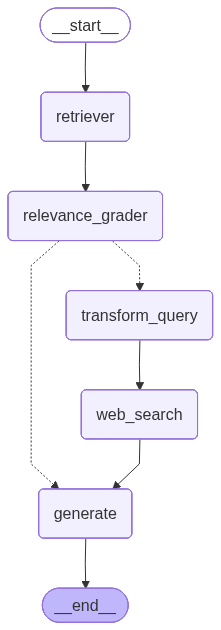

In [ ]:
from langgraph.graph import StateGraph,START,END

graph_builder = StateGraph(RAGState)

#add nodes
graph_builder.add_node('retriever',retrieve_from_documents)
graph_builder.add_node('relevance_grader',grade_documents)
graph_builder.add_node('transform_query',transform_query)
graph_builder.add_node('web_search',web_search)
graph_builder.add_node('generate',generate)
#graph_builder.add_node('route',route)

#add edges
graph_builder.add_edge(START,'retriever')
graph_builder.add_edge('retriever','relevance_grader')
graph_builder.add_conditional_edges('relevance_grader',
                                    route,
                                    {'transform_query':'transform_query',
                                    'generate':'generate'})
graph_builder.add_edge('transform_query','web_search')
graph_builder.add_edge('web_search','generate')

graph = graph_builder.compile()
graph

In [ ]:
graph.invoke({"question":"What is machine learning"})

RETRIEVE FROM DOCUMENTS...
CHECKING DOCUMENT RELEVANCE...
ROUTING...
DOCUMENTS ARE NOT RELEVANT TO QUESTION, REGENERATE QUESTION
TRANSFORMING QUERY...
WEB SEARCH...


C:\Users\redhu\AppData\Local\Temp\ipykernel_27240\2402895334.py:13: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(


GENERATING ANSWER...


{'question': 'What are the fundamental concepts and principles of machine learning?',
 'answer': AIMessage(content="Machine learning (ML) is a dynamic subset of artificial intelligence (AI) that empowers computers to learn from data, identify patterns, and make decisions with minimal human intervention. The fundamental concepts and principles of machine learning can be summarized as follows:\n\n### Core Concepts of Machine Learning\n\n1. **Types of Learning**:\n   - **Supervised Learning**: In this approach, models learn from labeled data, where the input data is paired with the correct output. The goal is to make predictions based on new, unseen data. Common applications include classification and regression tasks.\n   - **Unsupervised Learning**: This method involves training models on unlabeled data to discover hidden patterns or intrinsic structures. It is often used for clustering and association tasks, where the model identifies groupings or relationships within the data.\n   - *